In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Sales Forecast**

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwyc26wkk/uzgpv_e6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwyc26wkk/88kiuuyn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3245', 'data', 'file=/tmp/tmpwyc26wkk/uzgpv_e6.json', 'init=/tmp/tmpwyc26wkk/88kiuuyn.json', 'output', 'file=/tmp/tmpwyc26wkk/prophet_modelnifyhncl/prophet_model-20241004184101.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:41:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwyc26wkk/j

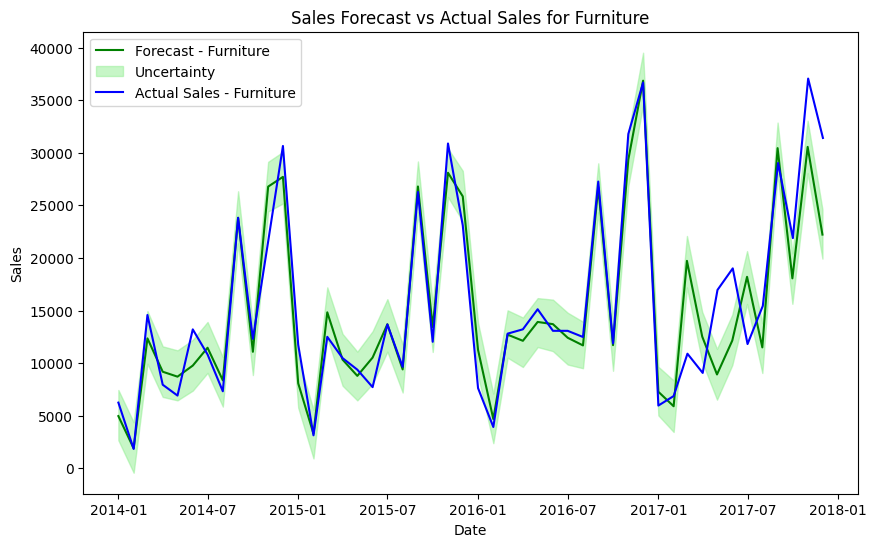

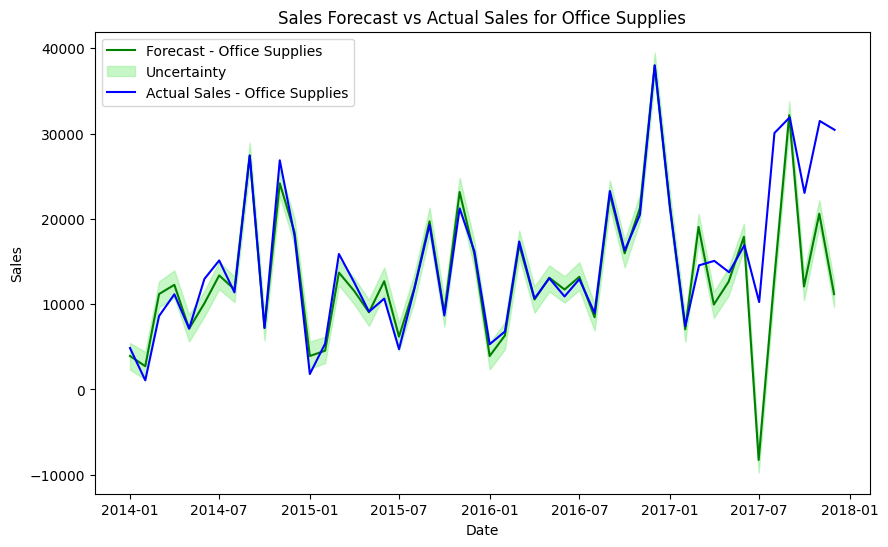

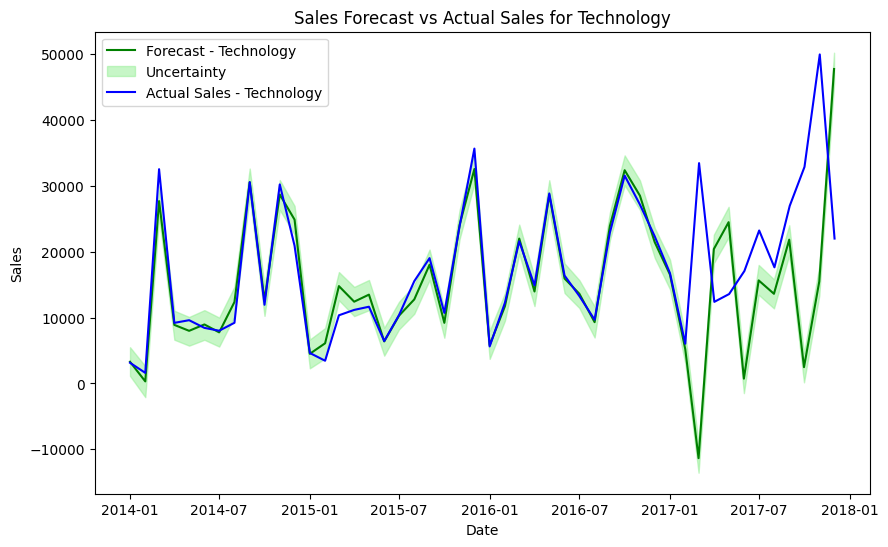


Classification report for Furniture:
              precision    recall  f1-score   support

   Low Sales       0.81      0.71      0.76        24
  High Sales       0.74      0.83      0.78        24

    accuracy                           0.77        48
   macro avg       0.78      0.77      0.77        48
weighted avg       0.78      0.77      0.77        48

MAE for Furniture: 2321.31
RMSE for Furniture: 3338.61
R² for Furniture: 0.86

Classification report for Office Supplies:
              precision    recall  f1-score   support

   Low Sales       0.95      0.79      0.86        24
  High Sales       0.82      0.96      0.88        24

    accuracy                           0.88        48
   macro avg       0.89      0.88      0.87        48
weighted avg       0.89      0.88      0.87        48

MAE for Office Supplies: 2550.99
RMSE for Office Supplies: 5333.11
R² for Office Supplies: 0.60

Classification report for Technology:
              precision    recall  f1-score   suppo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score

# 1. Load and preprocess the dataset
df = pd.read_csv('/content/drive/My Drive/Coimbatore Hackathon/Sample - Superstore.csv', encoding='latin-1')

# Handle missing values (if any)
df.dropna(subset=['Sales', 'Order Date'], inplace=True)

# Convert 'Order Date' to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d-%m-%Y')

# Aggregate sales by Category and Order Date (monthly)
df_grouped = df.groupby(['Category', df['Order Date'].dt.to_period("M")])['Sales'].sum().reset_index()
df_grouped['Order Date'] = df_grouped['Order Date'].dt.to_timestamp()

# Apply standard scaling to sales data
scaler = StandardScaler()
df_grouped['Sales_scaled'] = scaler.fit_transform(df_grouped[['Sales']])

# List of categories
categories = df_grouped['Category'].unique()

# Prepare forecast results storage
forecast_results = pd.DataFrame()

for category in categories:
    # Filter data by category and use scaled sales
    category_data = df_grouped[df_grouped['Category'] == category].rename(columns={'Order Date': 'ds', 'Sales_scaled': 'y'})

    # Split into training and testing sets (80% training)
    train_size = int(len(category_data) * 0.8)
    train = category_data[:train_size]
    test = category_data[train_size:]

    # Initialize Prophet model with US holidays and seasonality adjustments
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )

    # Add US holidays to the model
    model.add_country_holidays(country_name='US')

    # Add extra seasonality for Office Supplies and Technology
    if category in ['Office Supplies', 'Technology']:
        model.add_seasonality(name='quarterly', period=91.25, fourier_order=8)

    # Train model
    model.fit(train)

    # Create future dataframe and make predictions
    future = model.make_future_dataframe(periods=len(test), freq='M')

    forecast = model.predict(future)

    # Inverse transform the forecasted values to the original scale
    forecast['yhat_orig'] = scaler.inverse_transform(forecast[['yhat']])
    forecast['yhat_lower_orig'] = scaler.inverse_transform(forecast[['yhat_lower']])
    forecast['yhat_upper_orig'] = scaler.inverse_transform(forecast[['yhat_upper']])

    # Store forecast results
    forecast['Category'] = category
    forecast_results = pd.concat([forecast_results, forecast[['ds', 'yhat_orig', 'yhat_lower_orig', 'yhat_upper_orig', 'Category']]])

# 3. Visualize forecasts for each category
for category in categories:
    plt.figure(figsize=(10, 6))
    category_forecast = forecast_results[forecast_results['Category'] == category]

    plt.plot(category_forecast['ds'], category_forecast['yhat_orig'], label=f'Forecast - {category}', color='green')
    plt.fill_between(category_forecast['ds'], category_forecast['yhat_lower_orig'], category_forecast['yhat_upper_orig'], color='lightgreen', alpha=0.5, label='Uncertainty')

    category_actual = df_grouped[df_grouped['Category'] == category].rename(columns={'Order Date': 'ds', 'Sales': 'y'})
    plt.plot(category_actual['ds'], category_actual['y'], label=f'Actual Sales - {category}', color='blue')

    plt.title(f'Sales Forecast vs Actual Sales for {category}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

# 4. Evaluate the model for each category and generate classification report
for category in categories:
    category_forecast = forecast_results[forecast_results['Category'] == category]
    category_actual = df_grouped[df_grouped['Category'] == category].rename(columns={'Order Date': 'ds', 'Sales': 'y'})

    y_true = category_actual['y'].values[len(category_actual) - len(category_forecast):]  # Actual sales for the test period
    y_pred = category_forecast['yhat_orig'].values[:len(y_true)]  # Predicted sales

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)  # Set squared=False to get RMSE
    r2 = r2_score(y_true, y_pred)

    # Set a threshold (e.g., median sales) to classify sales as 'High' or 'Low'
    sales_threshold = category_actual['y'].median()

    # Create binary labels for classification ('High Sales' or 'Low Sales')
    y_true_class = ['High' if val > sales_threshold else 'Low' for val in y_true]
    y_pred_class = ['High' if val > sales_threshold else 'Low' for val in y_pred]

    # Print classification report and metrics
    print(f"\nClassification report for {category}:")
    print(classification_report(y_true_class, y_pred_class, target_names=['Low Sales', 'High Sales']))
    print(f'MAE for {category}: {mae:.2f}')
    print(f'RMSE for {category}: {rmse:.2f}')
    print(f'R² for {category}: {r2:.2f}')


##**Sales Forecast - with Holidays**

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwyc26wkk/idn1x3tj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwyc26wkk/_09ieuw7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99477', 'data', 'file=/tmp/tmpwyc26wkk/idn1x3tj.json', 'init=/tmp/tmpwyc26wkk/_09ieuw7.json', 'output', 'file=/tmp/tmpwyc26wkk/prophet_model0lm14h6o/prophet_model-20241004184104.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:41:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwyc26wkk/

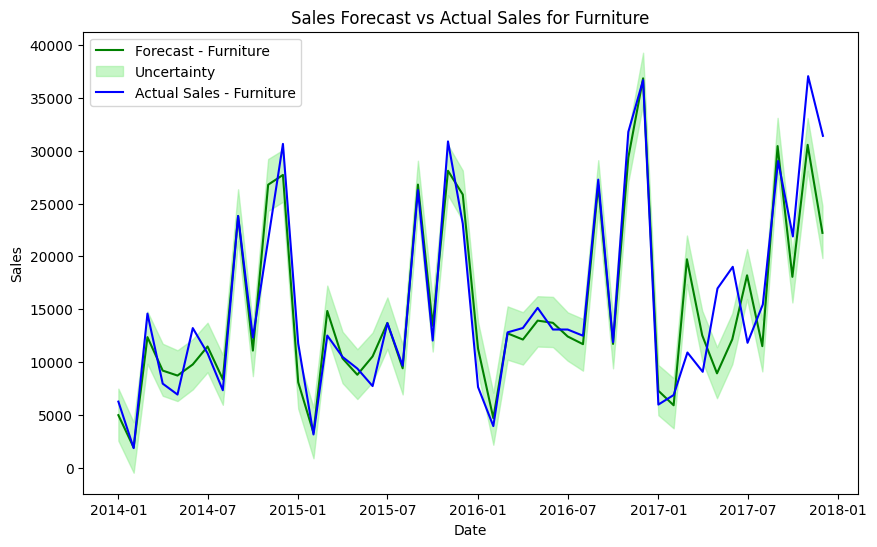

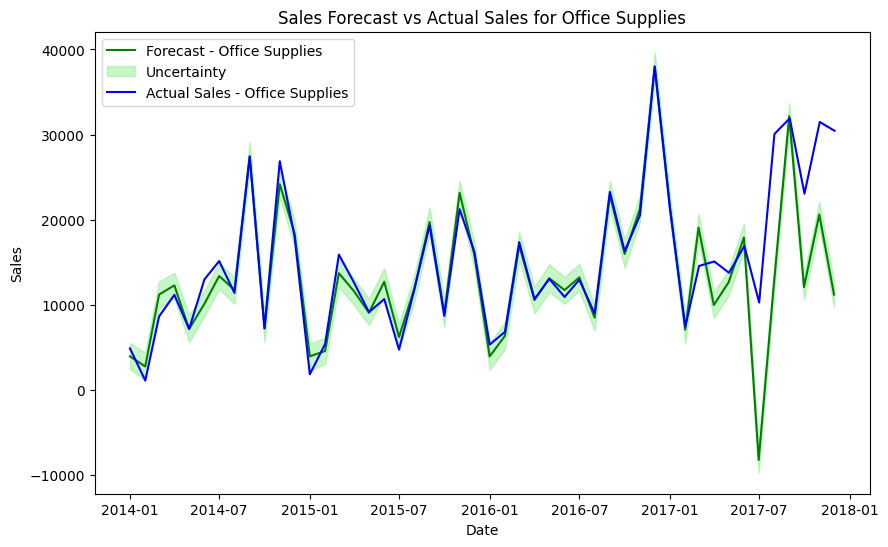

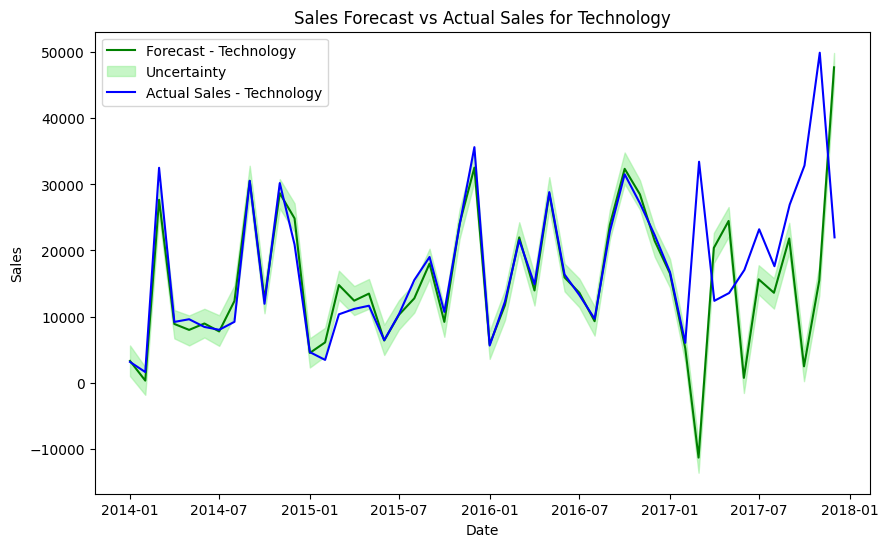

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Classification report for Furniture:
              precision    recall  f1-score   support

   Low Sales       0.81      0.71      0.76        24
  High Sales       0.74      0.83      0.78        24

    accuracy                           0.77        48
   macro avg       0.78      0.77      0.77        48
weighted avg       0.78      0.77      0.77        48

MAE for Furniture: 2321.31
RMSE for Furniture: 3338.61
R² for Furniture: 0.86

Classification report for Office Supplies:
              precision    recall  f1-score   support

   Low Sales       0.95      0.79      0.86        24
  High Sales       0.82      0.96      0.88        24

    accuracy                           0.88        48
   macro avg       0.89      0.88      0.87        48
weighted avg       0.89      0.88      0.87        48

MAE for Office Supplies: 2550.99
RMSE for Office Supplies: 5333.11
R² for Office Supplies: 0.60

Classification report for Technology:
              precision    recall  f1-score   suppo

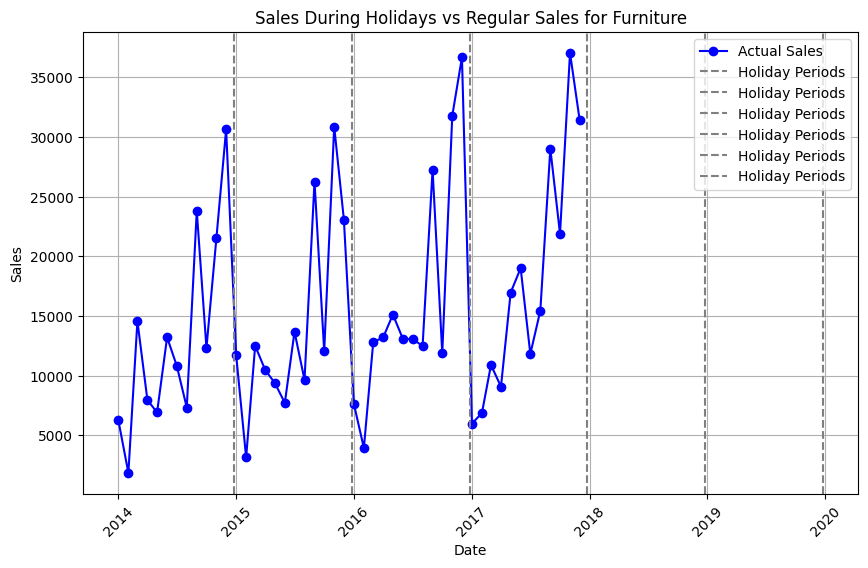

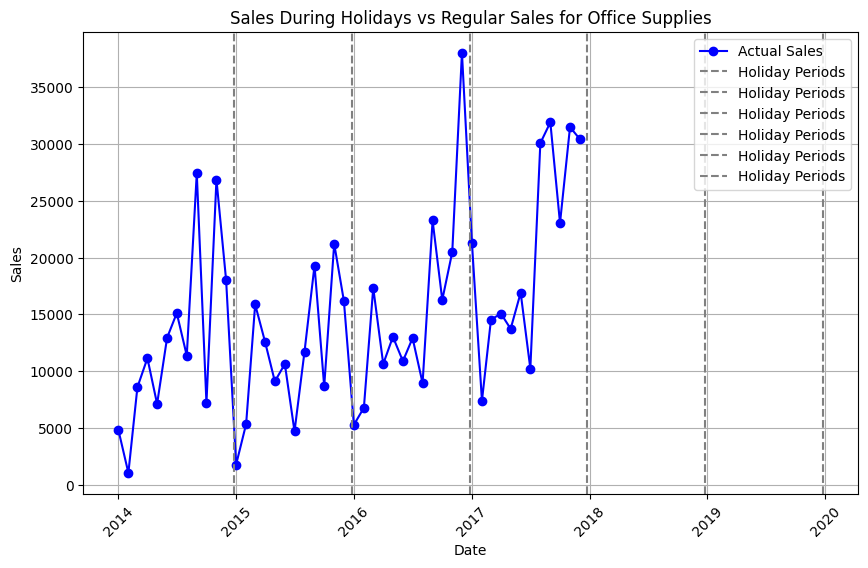

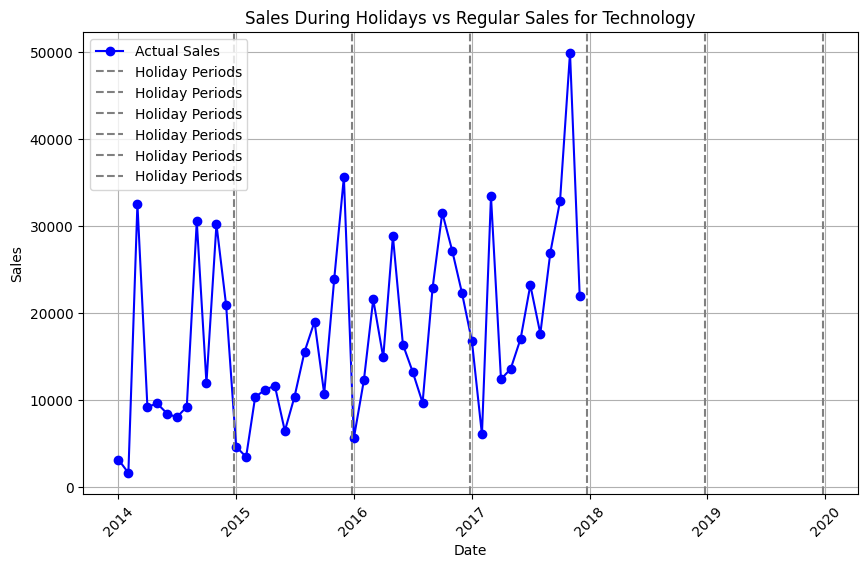

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score

# 1. Load and preprocess the dataset
df = pd.read_csv('/content/drive/My Drive/Coimbatore Hackathon/Sample - Superstore.csv', encoding='latin-1')

# Handle missing values (if any)
df.dropna(subset=['Sales', 'Order Date'], inplace=True)

# Convert 'Order Date' to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d-%m-%Y')

# Aggregate sales by Category and Order Date (monthly)
df_grouped = df.groupby(['Category', df['Order Date'].dt.to_period("M")])['Sales'].sum().reset_index()
df_grouped['Order Date'] = df_grouped['Order Date'].dt.to_timestamp()

# Apply standard scaling to sales data
scaler = StandardScaler()
df_grouped['Sales_scaled'] = scaler.fit_transform(df_grouped[['Sales']])

# List of categories
categories = df_grouped['Category'].unique()

# Prepare forecast results storage
forecast_results = pd.DataFrame()

for category in categories:
    # Filter data by category and use scaled sales
    category_data = df_grouped[df_grouped['Category'] == category].rename(columns={'Order Date': 'ds', 'Sales_scaled': 'y'})

    # Split into training and testing sets (80% training)
    train_size = int(len(category_data) * 0.8)
    train = category_data[:train_size]
    test = category_data[train_size:]

    # Initialize Prophet model with US holidays and seasonality adjustments
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )

    # Add US holidays to the model
    model.add_country_holidays(country_name='US')

    # Add extra seasonality for Office Supplies and Technology
    if category in ['Office Supplies', 'Technology']:
        model.add_seasonality(name='quarterly', period=91.25, fourier_order=8)

    # Train model
    model.fit(train)

    # Create future dataframe and make predictions
    future = model.make_future_dataframe(periods=len(test), freq='M')

    forecast = model.predict(future)

    # Inverse transform the forecasted values to the original scale
    forecast['yhat_orig'] = scaler.inverse_transform(forecast[['yhat']])
    forecast['yhat_lower_orig'] = scaler.inverse_transform(forecast[['yhat_lower']])
    forecast['yhat_upper_orig'] = scaler.inverse_transform(forecast[['yhat_upper']])

    # Store forecast results
    forecast['Category'] = category
    forecast_results = pd.concat([forecast_results, forecast[['ds', 'yhat_orig', 'yhat_lower_orig', 'yhat_upper_orig', 'Category']]])

# 3. Visualize forecasts for each category
for category in categories:
    plt.figure(figsize=(10, 6))
    category_forecast = forecast_results[forecast_results['Category'] == category]

    plt.plot(category_forecast['ds'], category_forecast['yhat_orig'], label=f'Forecast - {category}', color='green')
    plt.fill_between(category_forecast['ds'], category_forecast['yhat_lower_orig'], category_forecast['yhat_upper_orig'], color='lightgreen', alpha=0.5, label='Uncertainty')

    category_actual = df_grouped[df_grouped['Category'] == category].rename(columns={'Order Date': 'ds', 'Sales': 'y'})
    plt.plot(category_actual['ds'], category_actual['y'], label=f'Actual Sales - {category}', color='blue')

    plt.title(f'Sales Forecast vs Actual Sales for {category}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

# 4. Evaluate the model for each category and generate classification report
for category in categories:
    category_forecast = forecast_results[forecast_results['Category'] == category]
    category_actual = df_grouped[df_grouped['Category'] == category].rename(columns={'Order Date': 'ds', 'Sales': 'y'})

    y_true = category_actual['y'].values[len(category_actual) - len(category_forecast):]  # Actual sales for the test period
    y_pred = category_forecast['yhat_orig'].values[:len(y_true)]  # Predicted sales

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)  # Set squared=False to get RMSE
    r2 = r2_score(y_true, y_pred)

    # Set a threshold (e.g., median sales) to classify sales as 'High' or 'Low'
    sales_threshold = category_actual['y'].median()

    # Create binary labels for classification ('High Sales' or 'Low Sales')
    y_true_class = ['High' if val > sales_threshold else 'Low' for val in y_true]
    y_pred_class = ['High' if val > sales_threshold else 'Low' for val in y_pred]

    # Print classification report and metrics
    print(f"\nClassification report for {category}:")
    print(classification_report(y_true_class, y_pred_class, target_names=['Low Sales', 'High Sales']))
    print(f'MAE for {category}: {mae:.2f}')
    print(f'RMSE for {category}: {rmse:.2f}')
    print(f'R² for {category}: {r2:.2f}')

# 5. Analyze and visualize holiday sales for each category
# Define the holiday periods (you can modify this to fit your dataset)
holidays = ['2014-12-25', '2015-12-25', '2016-12-25', '2017-12-25', '2018-12-25', '2019-12-25']  # Example: Christmas
holidays = pd.to_datetime(holidays)

for category in categories:
    plt.figure(figsize=(10, 6))

    # Actual sales data for the category
    category_actual = df_grouped[df_grouped['Category'] == category]

    # Plot actual sales
    plt.plot(category_actual['Order Date'], category_actual['Sales'], label='Actual Sales', color='blue', marker='o')

    # Highlight holiday sales
    holiday_sales = category_actual[category_actual['Order Date'].isin(holidays)]
    if not holiday_sales.empty:
        plt.scatter(holiday_sales['Order Date'], holiday_sales['Sales'], color='red', label='Holiday Sales', s=200, edgecolor='black', alpha=0.7)

    plt.title(f'Sales During Holidays vs Regular Sales for {category}')
    plt.xlabel('Date')
    plt.ylabel('Sales')

    # If you have specific holidays defined
    for holiday in holidays:
        plt.axvline(x=holiday, color='gray', linestyle='--', label='Holiday Periods')

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend()
    plt.grid()
    plt.show()

##**Dynamic Pricing**

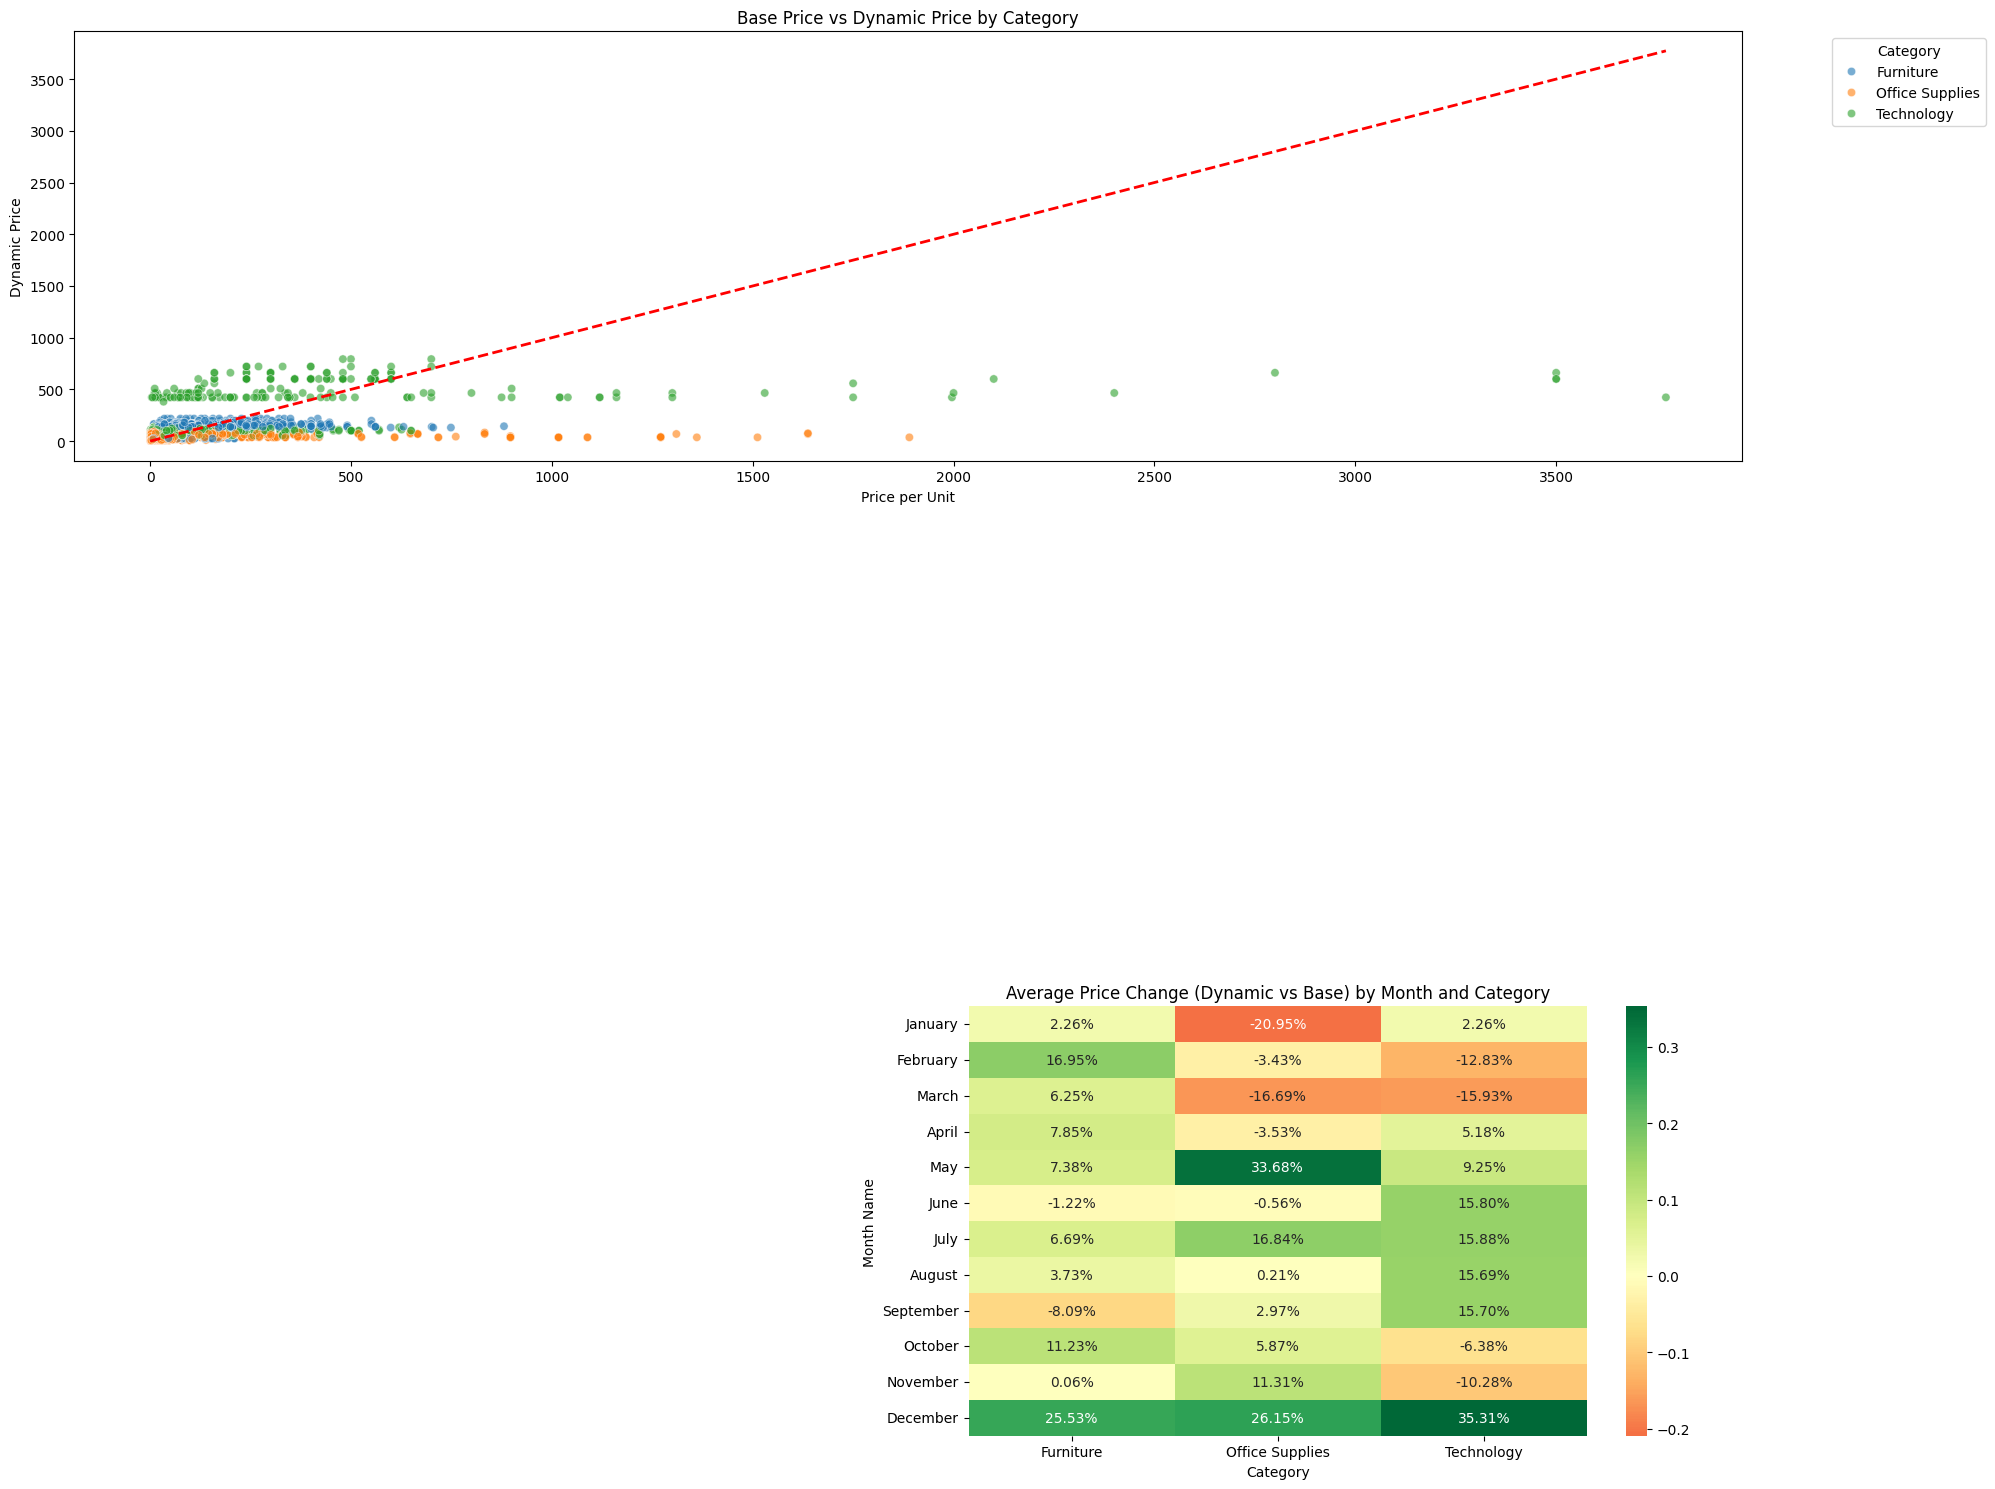

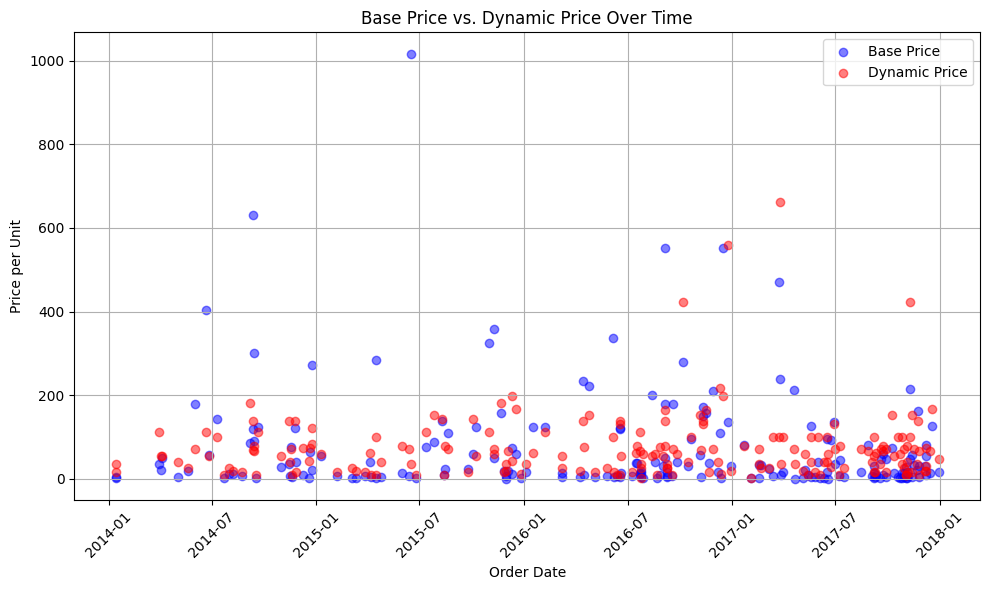

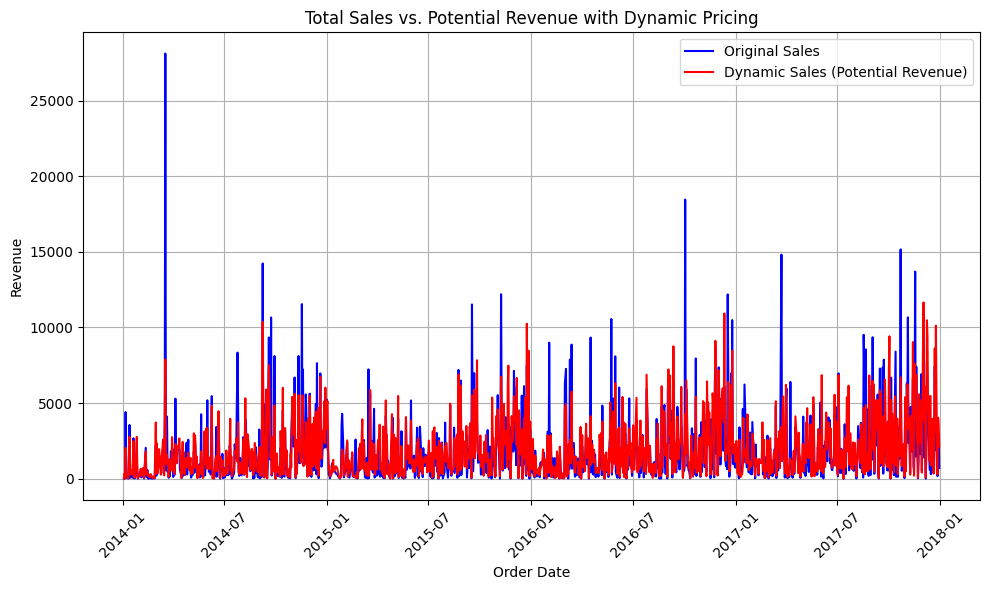

Total original sales: 2297200.86
Total sales with dynamic pricing: 2421577.89
Sales change after dynamic pricing: 124377.03
Percentage change in sales: 5.41%


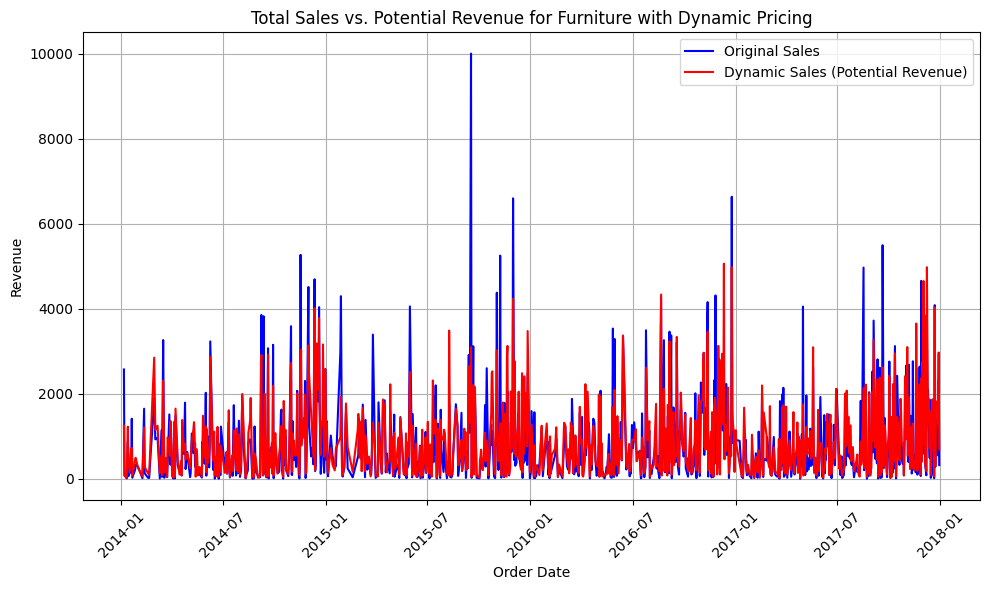

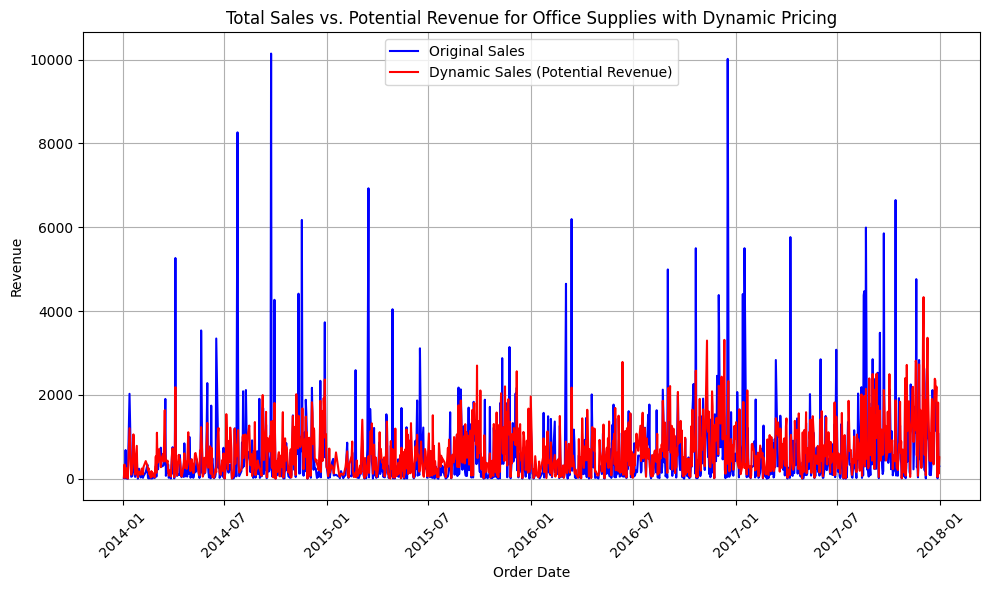

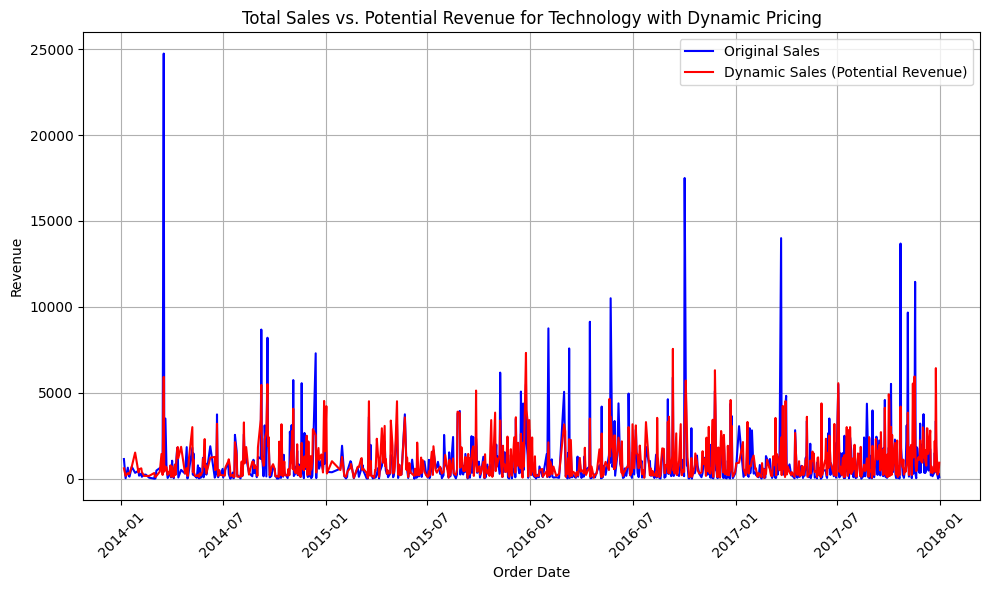


Percentage Change in Sales by Category:
Furniture: 5.13%
Office Supplies: 7.44%
Technology: 3.93%

Overall Percentage Change in Sales: 5.41%


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Load the dataset (replace with your actual file path)
df = pd.read_csv('/content/drive/My Drive/Coimbatore Hackathon/Sample - Superstore.csv', encoding='latin-1')

# Convert 'Order Date' to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d-%m-%Y')

# Create new features: Day of the week, Month
df['Day of Week'] = df['Order Date'].dt.dayofweek
df['Month'] = df['Order Date'].dt.month

# Calculate current price per unit
df['Price per Unit'] = df['Sales'] / df['Quantity']

# Base price: Calculate the average price per unit across historical data for each product or sub-category
base_price = df.groupby('Sub-Category')['Price per Unit'].mean().to_dict()

# Function to adjust the price based on dynamic factors
def dynamic_pricing(row):
    sub_category = row['Sub-Category']
    quantity = row['Quantity']

    # Get base price for the current product
    price = base_price.get(sub_category, 100)  # Default to 100 if no base price found

    # Weekend pricing (increase price on weekends)
    if row['Day of Week'] >= 5:  # Saturday (5) or Sunday (6)
        price *= 1.1  # Increase by 10%

    # Seasonal pricing (increase prices during holiday months, e.g., December)
    if row['Month'] == 12:
        price *= 1.2  # Increase by 20%

    # Bulk discount (give discount for large orders)
    if quantity >= 10:
        price *= 0.9  # 10% discount for bulk orders

    return price

# Apply dynamic pricing to each row
df['Dynamic Price'] = df.apply(dynamic_pricing, axis=1)

# Calculate potential revenue with dynamic pricing
df['Potential Revenue'] = df['Dynamic Price'] * df['Quantity']

# ----------- Approach 1 Plots (Integrated) -----------------
# Create a figure with a grid layout for Approach 1 plots
fig = plt.figure(figsize=(20, 15))
gs = GridSpec(3, 2, figure=fig)

# 1. Scatter plot: Base Price vs Dynamic Price
ax1 = fig.add_subplot(gs[0, :])
sns.scatterplot(data=df, x='Price per Unit', y='Dynamic Price', hue='Category', alpha=0.6, ax=ax1)
ax1.plot([df['Price per Unit'].min(), df['Price per Unit'].max()],
         [df['Price per Unit'].min(), df['Price per Unit'].max()],
         'r--', lw=2)
ax1.set_title('Base Price vs Dynamic Price by Category')
ax1.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')


# 2. Heatmap: Average price change by month and category
ax4 = fig.add_subplot(gs[2, 1])
df['Month Name'] = df['Order Date'].dt.month_name()
price_change = df.groupby(['Month Name', 'Category'])['Dynamic Price'].mean() / df.groupby(['Month Name', 'Category'])['Price per Unit'].mean() - 1
price_change = price_change.unstack()
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
price_change = price_change.reindex(month_order)
sns.heatmap(price_change, annot=True, fmt='.2%', cmap='RdYlGn', center=0, ax=ax4)
ax4.set_title('Average Price Change (Dynamic vs Base) by Month and Category')

plt.tight_layout()
plt.show()

# ----------- Approach 2 Plots (Original) -----------------
# Visualization: Comparison of Base Price vs. Dynamic Price
plt.figure(figsize=(10, 6))
df_sample = df.sample(200)  # Sampling 200 random rows for better visualization
plt.scatter(df_sample['Order Date'], df_sample['Price per Unit'], color='blue', label='Base Price', alpha=0.5)
plt.scatter(df_sample['Order Date'], df_sample['Dynamic Price'], color='red', label='Dynamic Price', alpha=0.5)
plt.title('Base Price vs. Dynamic Price Over Time')
plt.xlabel('Order Date')
plt.ylabel('Price per Unit')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization: Total Sales vs. Potential Revenue with Dynamic Pricing
plt.figure(figsize=(10, 6))
original_sales = df.groupby('Order Date')['Sales'].sum()
dynamic_sales = df.groupby('Order Date')['Potential Revenue'].sum()
plt.plot(original_sales.index, original_sales.values, color='blue', label='Original Sales')
plt.plot(dynamic_sales.index, dynamic_sales.values, color='red', label='Dynamic Sales (Potential Revenue)')
plt.title('Total Sales vs. Potential Revenue with Dynamic Pricing')
plt.xlabel('Order Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ----------- Summary of results -----------------
total_original_sales = df['Sales'].sum()
total_dynamic_sales = df['Potential Revenue'].sum()

print(f"Total original sales: {total_original_sales:.2f}")
print(f"Total sales with dynamic pricing: {total_dynamic_sales:.2f}")
print(f"Sales change after dynamic pricing: {total_dynamic_sales - total_original_sales:.2f}")
print(f"Percentage change in sales: {((total_dynamic_sales - total_original_sales) / total_original_sales) * 100:.2f}%")

# Plotting total sales vs potential revenue for each category
for category in categories:
    plt.figure(figsize=(10, 6))
    original_sales_cat = df[df['Category'] == category].groupby('Order Date')['Sales'].sum()
    dynamic_sales_cat = df[df['Category'] == category].groupby('Order Date')['Potential Revenue'].sum()
    plt.plot(original_sales_cat.index, original_sales_cat.values, color='blue', label='Original Sales')
    plt.plot(dynamic_sales_cat.index, dynamic_sales_cat.values, color='red', label='Dynamic Sales (Potential Revenue)')
    plt.title(f'Total Sales vs. Potential Revenue for {category} with Dynamic Pricing')
    plt.xlabel('Order Date')
    plt.ylabel('Revenue')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
# ----------- Percentage Change in Sales by Category -----------------
categories = df['Category'].unique()
print("\nPercentage Change in Sales by Category:")
for category in categories:
    total_original_sales_category = df[df['Category'] == category]['Sales'].sum()
    total_dynamic_sales_category = df[df['Category'] == category]['Potential Revenue'].sum()
    percentage_change_category = ((total_dynamic_sales_category - total_original_sales_category) / total_original_sales_category) * 100
    print(f"{category}: {percentage_change_category:.2f}%")
# Overall Percentage Change in Sales
overall_percentage_change = ((total_dynamic_sales - total_original_sales) / total_original_sales) * 100
print(f"\nOverall Percentage Change in Sales: {overall_percentage_change:.2f}%")


## **Demand Forecasting**


DEBUG:cmdstanpy:input tempfile: /tmp/tmpwyc26wkk/ooi7i_zk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwyc26wkk/hh383lzi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17292', 'data', 'file=/tmp/tmpwyc26wkk/ooi7i_zk.json', 'init=/tmp/tmpwyc26wkk/hh383lzi.json', 'output', 'file=/tmp/tmpwyc26wkk/prophet_modelgze8e4kr/prophet_model-20241004184115.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:41:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwyc26wkk/

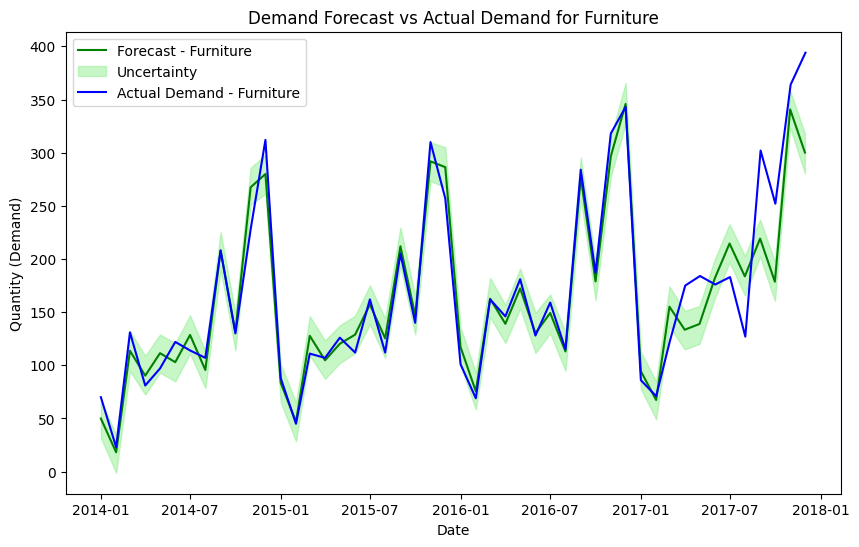

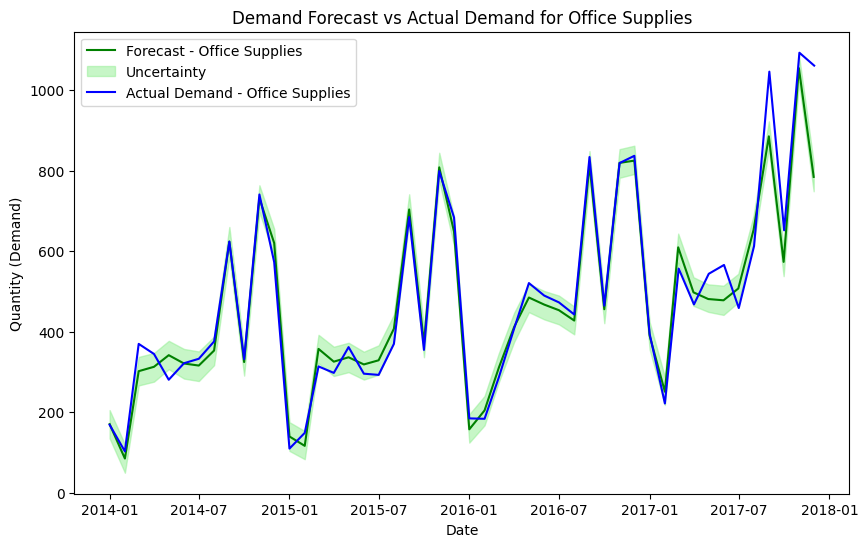

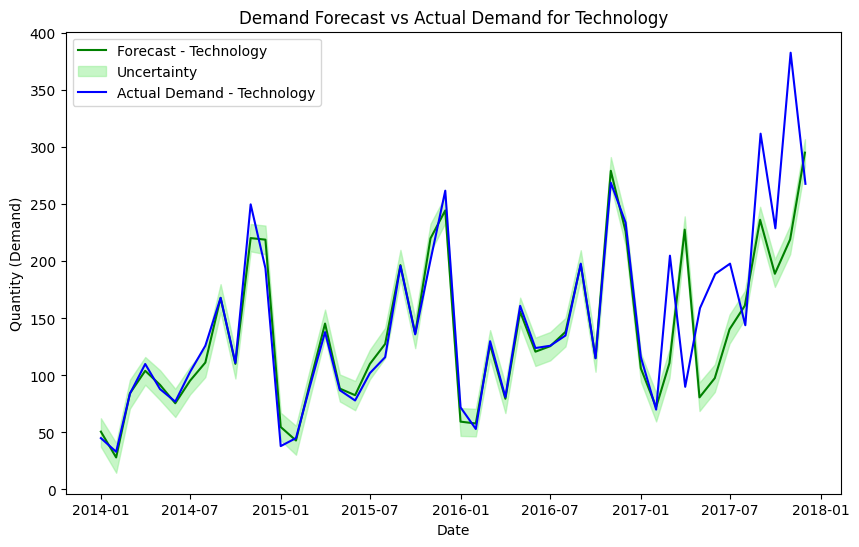


Demand Forecasting Evaluation for Furniture:
MAE: 18.78
RMSE: 28.23
R²: 0.90
Predicted demand increase for next period: -23.82%

Demand Forecasting Evaluation for Office Supplies:
MAE: 36.20
RMSE: 57.37
R²: 0.94
Predicted demand increase for next period: -26.05%

Demand Forecasting Evaluation for Technology:
MAE: 21.68
RMSE: 41.94
R²: 0.70
Predicted demand increase for next period: 10.21%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score

# 1. Load and preprocess the dataset
df = pd.read_csv('/content/drive/My Drive/Coimbatore Hackathon/Sample - Superstore.csv', encoding='latin-1')

# Handle missing values (if any)
df.dropna(subset=['Quantity', 'Order Date'], inplace=True)

# Convert 'Order Date' to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d-%m-%Y')

# Aggregate quantity by Category and Order Date (monthly)
df_grouped = df.groupby(['Category', df['Order Date'].dt.to_period("M")])['Quantity'].sum().reset_index()
df_grouped['Order Date'] = df_grouped['Order Date'].dt.to_timestamp()

# Apply standard scaling to quantity data
scaler = StandardScaler()
df_grouped['Quantity_scaled'] = scaler.fit_transform(df_grouped[['Quantity']])

# List of categories
categories = df_grouped['Category'].unique()

# Prepare forecast results storage
forecast_results = pd.DataFrame()

for category in categories:
    # Filter data by category and use scaled quantity
    category_data = df_grouped[df_grouped['Category'] == category].rename(columns={'Order Date': 'ds', 'Quantity_scaled': 'y'})

    # Split into training and testing sets (80% training)
    train_size = int(len(category_data) * 0.8)
    train = category_data[:train_size]
    test = category_data[train_size:]

    # Initialize Prophet model with seasonality adjustments
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )

    # Add holidays and seasonality adjustments if needed
    model.add_country_holidays(country_name='US')

    # Train model
    model.fit(train)

    # Create future dataframe and make predictions
    future = model.make_future_dataframe(periods=len(test), freq='M')

    forecast = model.predict(future)

    # Inverse transform the forecasted values to the original scale
    forecast['yhat_orig'] = scaler.inverse_transform(forecast[['yhat']])
    forecast['yhat_lower_orig'] = scaler.inverse_transform(forecast[['yhat_lower']])
    forecast['yhat_upper_orig'] = scaler.inverse_transform(forecast[['yhat_upper']])

    # Store forecast results
    forecast['Category'] = category
    forecast_results = pd.concat([forecast_results, forecast[['ds', 'yhat_orig', 'yhat_lower_orig', 'yhat_upper_orig', 'Category']]])

# 3. Visualize forecasts for each category
for category in categories:
    plt.figure(figsize=(10, 6))
    category_forecast = forecast_results[forecast_results['Category'] == category]

    plt.plot(category_forecast['ds'], category_forecast['yhat_orig'], label=f'Forecast - {category}', color='green')
    plt.fill_between(category_forecast['ds'], category_forecast['yhat_lower_orig'], category_forecast['yhat_upper_orig'], color='lightgreen', alpha=0.5, label='Uncertainty')

    category_actual = df_grouped[df_grouped['Category'] == category].rename(columns={'Order Date': 'ds', 'Quantity': 'y'})
    plt.plot(category_actual['ds'], category_actual['y'], label=f'Actual Demand - {category}', color='blue')

    plt.title(f'Demand Forecast vs Actual Demand for {category}')
    plt.xlabel('Date')
    plt.ylabel('Quantity (Demand)')
    plt.legend()
    plt.show()

# 4. Evaluate the model for each category and identify demand increase
for category in categories:
    category_forecast = forecast_results[forecast_results['Category'] == category]
    category_actual = df_grouped[df_grouped['Category'] == category].rename(columns={'Order Date': 'ds', 'Quantity': 'y'})

    y_true = category_actual['y'].values[len(category_actual) - len(category_forecast):]  # Actual demand for the test period
    y_pred = category_forecast['yhat_orig'].values[:len(y_true)]  # Predicted demand

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)  # Set squared=False to get RMSE
    r2 = r2_score(y_true, y_pred)

    # Calculate percentage change in demand forecast
    actual_demand_last = y_true[-1]  # Actual demand in the last period
    predicted_demand_next = y_pred[-1]  # Predicted demand for the next period
    percentage_increase = ((predicted_demand_next - actual_demand_last) / actual_demand_last) * 100

    # Print metrics and demand increase info
    print(f"\nDemand Forecasting Evaluation for {category}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")
    print(f"Predicted demand increase for next period: {percentage_increase:.2f}%")


## **Profit Optimisation**


Classification Report for Profit Optimization (Decision Tree):
              precision    recall  f1-score   support

  Low Profit       1.00      1.00      1.00         1
 High Profit       1.00      1.00      1.00         2

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3


Mean Absolute Error (MAE): 0.00
Mean Squared Error (MSE): 0.00
Root Mean Squared Error (RMSE): 0.00
R² Score: 1.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


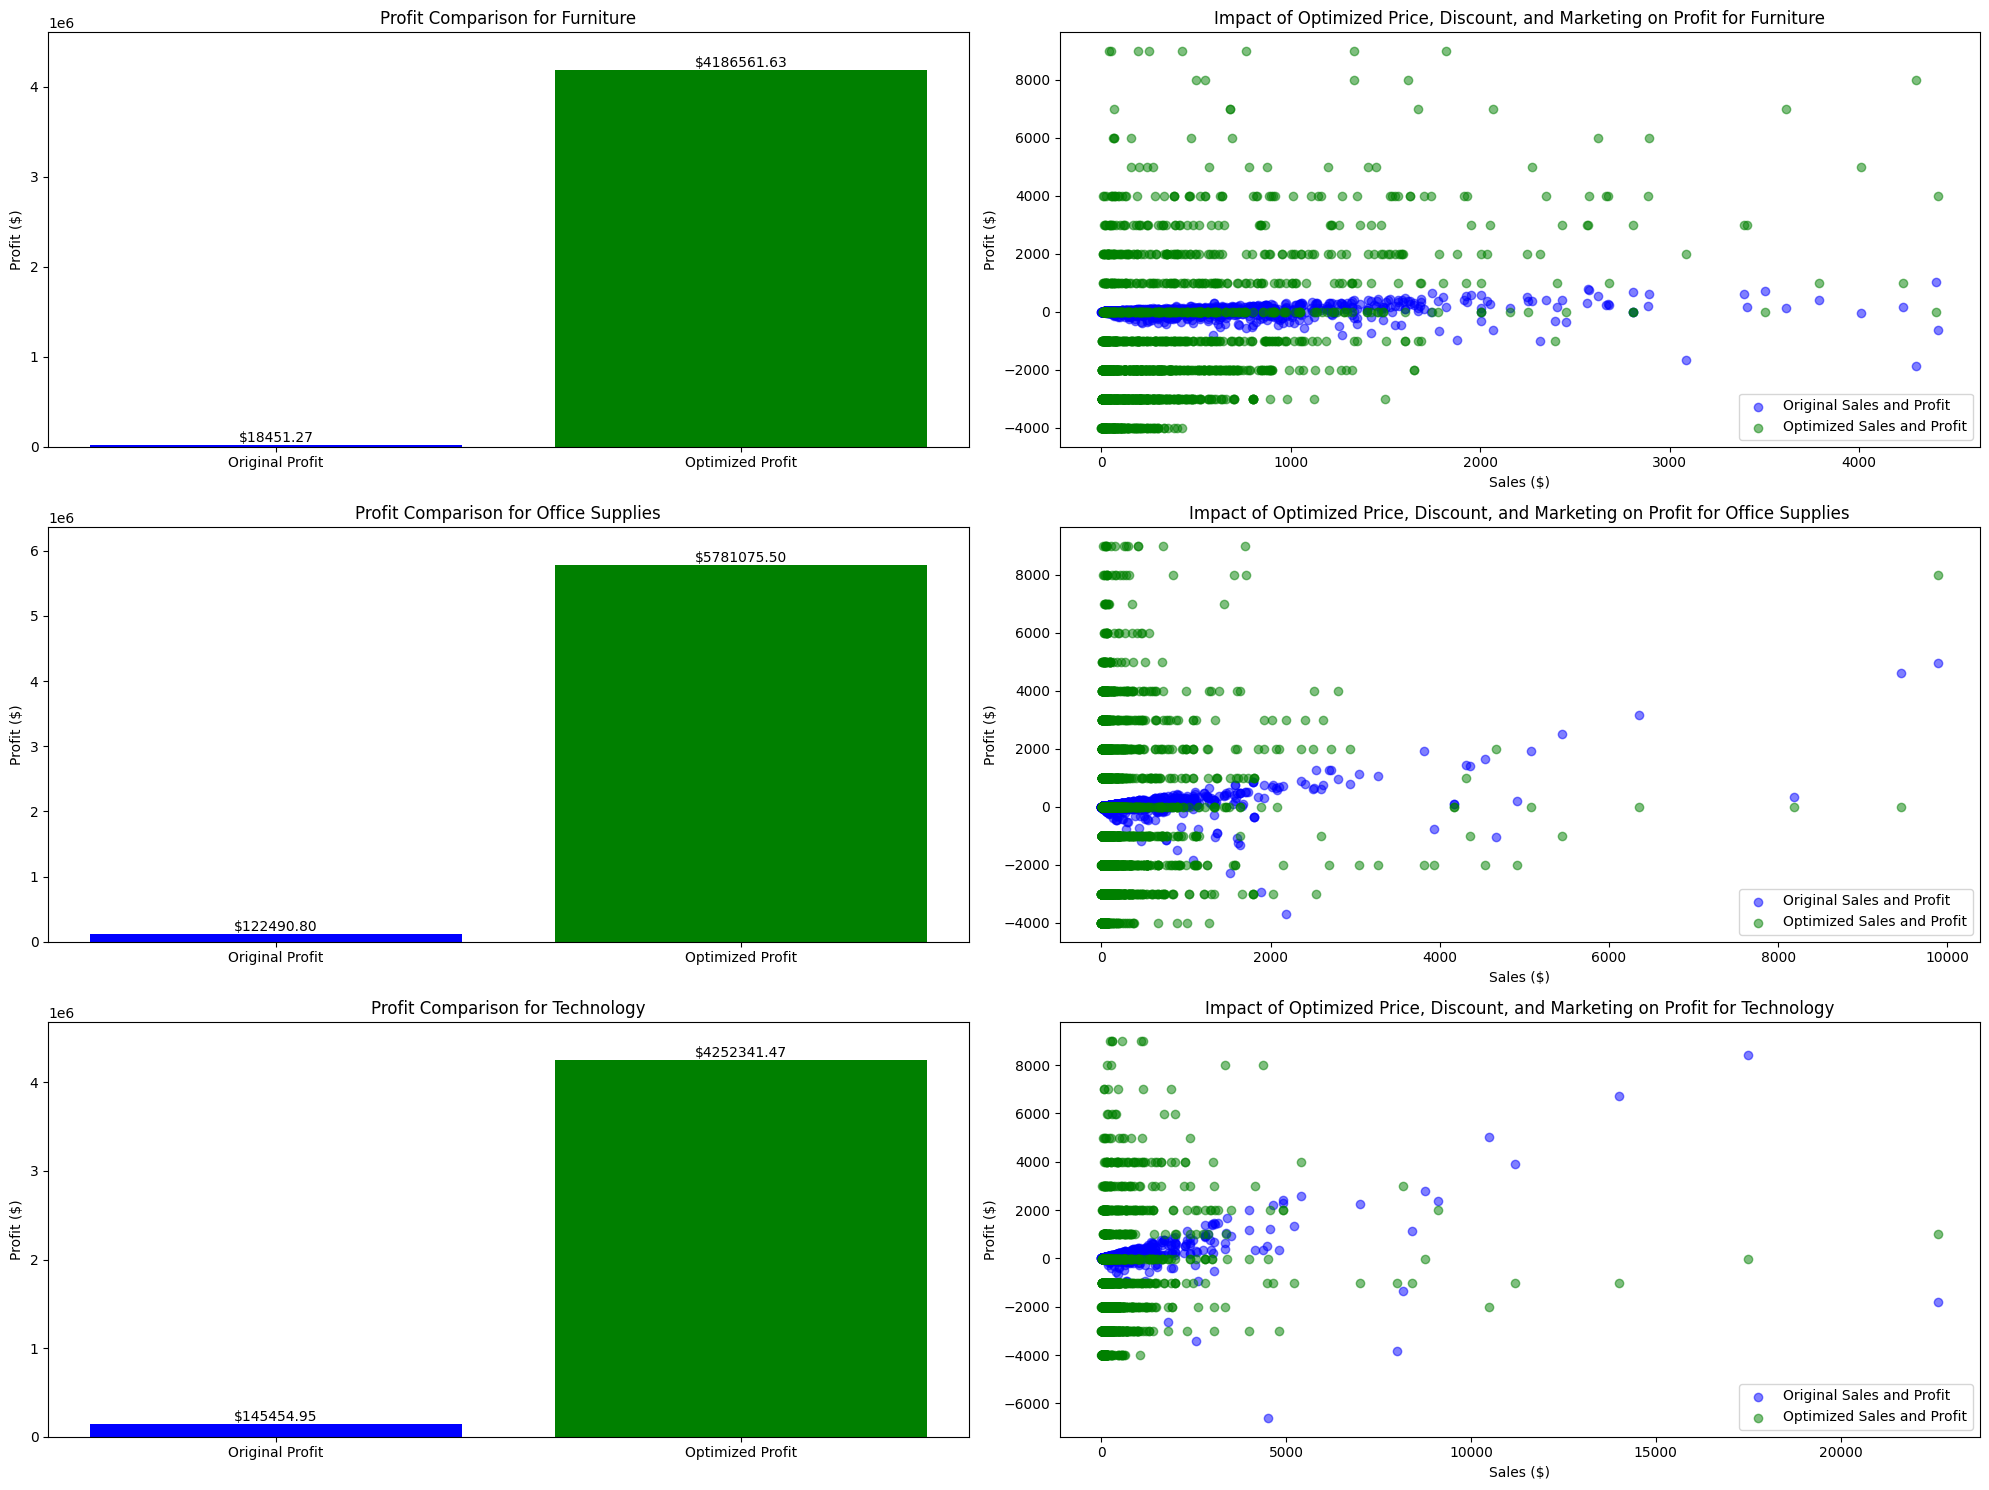

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Load the data (modify the path as needed)
df = pd.read_csv('/content/drive/My Drive/Coimbatore Hackathon/Sample - Superstore.csv', encoding='latin-1')

# Handle missing values and convert 'Order Date' to datetime format
df.dropna(subset=['Sales', 'Profit', 'Order Date', 'Quantity', 'Discount', 'Category', 'Product Name'], inplace=True)
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d-%m-%Y')

# List of categories
categories = df['Category'].unique()

# Create a dictionary to store optimized results for each category
optimized_results = {}

# Define a more refined profit function considering additional cost factors
def profit_function(params, data):
    price, discount, marketing_expenditure = params

    # Demand formula adjusted based on discount and marketing expenditure impact
    demand = (data['Quantity'].mean() * (1 - discount) * price) + (0.1 * marketing_expenditure)

    # Total sales and cost calculations
    total_sales = demand * price
    total_cost = data['Sales'].mean()  # Assuming average sales as cost; refine based on data availability

    # Calculate profit considering the effect of discounts and marketing
    profit = total_sales - total_cost - marketing_expenditure

    return -profit  # Return negative to maximize profit during optimization

# Iterate through each category and apply the optimization
for category in categories:
    category_data = df[df['Category'] == category]

    # Set initial guess for [price, discount, marketing expenditure]
    initial_guess = [100, 0.1, 5000]

    # Set realistic bounds based on dataset analysis
    bounds = [
        (10, 1000),   # Price bounds based on Sales statistics
        (0.0, 0.8),   # Discount bounds based on observed maximum discount
        (500, 20000)  # Marketing Expenditure bounds based on estimated budget
    ]

    # Run the optimization using a more advanced method or algorithm if needed
    result = minimize(profit_function, initial_guess, args=(category_data), bounds=bounds, method='SLSQP')

    # Extract optimized values
    optimized_price, optimized_discount, optimized_marketing = result.x
    maximum_profit = -result.fun  # Convert back to positive profit

    # Store results for the category
    optimized_results[category] = {
        'Optimized Price': f"${optimized_price:.2f}",
        'Optimized Discount': f"{optimized_discount * 100:.2f}%",
        'Optimized Marketing Expenditure': f"${optimized_marketing:.2f}",
        'Maximum Profit': maximum_profit,  # Store as float for plotting
        'Original Profit': category_data['Profit'].sum()  # Original profit before optimization
    }

# Prepare classification labels for each category based on relative profit change
y_true = []  # Original profit labels
y_pred = []  # Optimized profit labels

# Use the median original profit as the threshold for classification
original_profits = [optimized_results[cat]['Original Profit'] for cat in categories]
profit_threshold = np.median(original_profits)

# Classify each category based on relative profit improvement (>10%)
profit_improvement_threshold = 0.1

# Create a feature set for classification
classification_features = []

for category in categories:
    # Original profit classification
    original_profit = optimized_results[category]['Original Profit']
    y_true.append('High' if original_profit > profit_threshold else 'Low')

    # Optimized profit classification based on relative improvement
    optimized_profit = optimized_results[category]['Maximum Profit']
    if (optimized_profit - original_profit) / original_profit > profit_improvement_threshold:
        y_pred.append('High')
    else:
        y_pred.append('Low')

    # Features for classification
    classification_features.append([optimized_profit, original_profit])

# Convert labels to numeric using LabelEncoder
label_encoder = LabelEncoder()
y_true_numeric = label_encoder.fit_transform(y_true)  # Convert 'Low' to 0, 'High' to 1
y_pred_numeric = label_encoder.transform(y_pred)

# Use a decision tree classifier for better classification
classifier = DecisionTreeClassifier(max_depth=3, random_state=42)
classifier.fit(classification_features, y_true_numeric)

# Predict categories using classifier and print results
predicted_classes = classifier.predict(classification_features)
print("\nClassification Report for Profit Optimization (Decision Tree):")
print(classification_report(y_true_numeric, predicted_classes, target_names=['Low Profit', 'High Profit']))

# Calculate and print regression error metrics
mae = mean_absolute_error(y_true_numeric, predicted_classes)
mse = mean_squared_error(y_true_numeric, predicted_classes)
rmse = mean_squared_error(y_true_numeric, predicted_classes, squared=False)
r2 = r2_score(y_true_numeric, predicted_classes)

# Print regression evaluation metrics
print(f'\nMean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R² Score: {r2:.2f}')

# ----------- Plotting the results for each category -----------
# Create a figure with a grid layout for results
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(len(categories), 2)

# Iterate over categories to plot results
for idx, category in enumerate(categories):
    # Original and optimized profit for the category
    original_profit = optimized_results[category]['Original Profit']
    optimized_profit = optimized_results[category]['Maximum Profit']

    # 1. Bar plot for Original vs Optimized Profit
    ax1 = fig.add_subplot(gs[idx, 0])
    ax1.bar(['Original Profit', 'Optimized Profit'], [original_profit, optimized_profit], color=['blue', 'green'])
    ax1.set_title(f'Profit Comparison for {category}')
    ax1.set_ylabel('Profit ($)')
    ax1.set_ylim(0, max(original_profit, optimized_profit) * 1.1)
    ax1.text(0, original_profit, f"${original_profit:.2f}", ha='center', va='bottom')
    ax1.text(1, optimized_profit, f"${optimized_profit:.2f}", ha='center', va='bottom')

    # 2. Scatter plot of sales with original and optimized profits
    ax2 = fig.add_subplot(gs[idx, 1])
    category_data = df[df['Category'] == category]
    ax2.scatter(category_data['Sales'], category_data['Profit'], label='Original Sales and Profit', color='blue', alpha=0.5)

    # Calculate new profits using optimized parameters
    optimized_profit_values = category_data['Quantity'] * optimized_price * (1 - optimized_discount) - optimized_marketing
    ax2.scatter(category_data['Sales'], optimized_profit_values, label='Optimized Sales and Profit', color='green', alpha=0.5)

    ax2.set_title(f'Impact of Optimized Price, Discount, and Marketing on Profit for {category}')
    ax2.set_xlabel('Sales ($)')
    ax2.set_ylabel('Profit ($)')
    ax2.legend()

plt.tight_layout()
plt.show()


In [8]:
!pip freeze > requirements.txt
